In [1]:
from typing import List
import pandas
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os

image_size = 120

train_path = "train/"
test_path = "test/"

testLabels = os.listdir(test_path)
trainLabels = os.listdir(train_path)

def dataLoader(aboPath:str, paths:List[str]):
    inputs = []
    targets = []
    for index, i in enumerate(paths):
        sub = os.path.join(aboPath, i)
        imgdir = os.listdir(sub)
        # for i in imgdir:
        for i in imgdir:
            if not "Copy" in i:
                    
                image = keras.utils.load_img(
                    os.path.join(sub, i),
                )
                image = image.resize((image_size, image_size))
                inputs.append(keras.utils.img_to_array(image))
                targets.append(index)
    return (np.asarray(inputs)/255., np.asarray(targets)) 

val_data = dataLoader(test_path, testLabels)
train_data = dataLoader(train_path, trainLabels)

data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        # layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)


2023-12-12 11:24:30.129599: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-12 11:24:30.180728: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-12 11:24:30.180776: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-12 11:24:30.180851: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-12 11:24:30.200503: I tensorflow/core/platform/cpu_feature_g

In [31]:
vgg16 = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
for layer in vgg16.layers:     
    layer.trainable = True
x = layers.AveragePooling2D()(vgg16.input)
output = layers.Flatten()(x)
output = layers.Dense(1024, tf.nn.relu)(output)
output = layers.Dense(len(np.unique(val_data[1])))(output)
model = keras.Model(inputs = vgg16.input, outputs = output)

In [37]:
Xception = keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
for layer in Xception.layers:     
    layer.trainable = True

x = layers.Conv2D(32, 3)(Xception.input)
# x = layers.MaxPooling2D(x)
output = layers.Flatten()(x)
output = layers.Dense(1024, tf.nn.relu)(output)
output = layers.Dense(len(np.unique(val_data[1])))(output)
model = keras.Model(inputs = Xception.input, outputs = output)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, 120, 120, 3)       7         
 ial)                                                            
                                                                 
 conv2d_10 (CONV2D)          (None, 60, 60, 64)        2048      
                                                                 
 conv2d_12 (CONV2D)          (None, 30, 30, 128)       74368     
                                                                 
 conv2d_14 (CONV2D)          (None, 15, 15, 256)       296192    
                                                                 
 flatten_4 (Flatten)         (None, 57600)             0         
                                                           

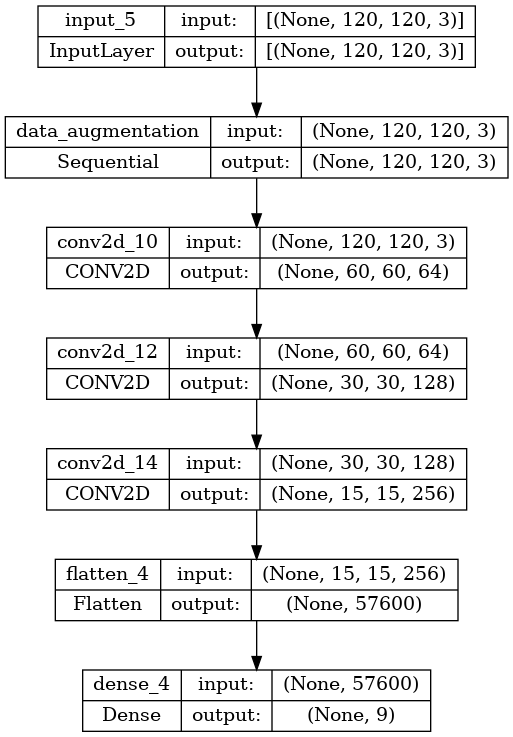

In [18]:

Input = keras.Input((image_size, image_size, 3))
x = data_augmentation(Input)

class CONV2D(layers.Layer):
    def __init__(self, kenel):
        super().__init__()
        self.x1 = layers.Conv2D(kenel, 3, activation = "relu", padding="same")
        self.x2 = layers.BatchNormalization()
        self.x3 = layers.MaxPooling2D()
        self.x4 = layers.Dropout(0.4)
    def call(self, x):
        x = self.x1(x)        
        x = self.x2(x)        
        x = self.x3(x)        
        x = self.x4(x) 
        return x       

x = CONV2D(64)(x)
x = CONV2D(128)(x)
x = CONV2D(256)(x)

x = layers.Flatten()(x)
x = layers.Dense(len(np.unique(val_data[1])), tf.nn.softmax)(x)

model = keras.Model(inputs = Input, outputs = x)
model.summary()

tf.keras.utils.plot_model(model, show_shapes=True)


In [38]:

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20) 
rLR = tf.keras.callbacks.ReduceLROnPlateau (
    monitor='val_loss',
    factor=0.6,
    patience=3,
    min_lr=1e-12,
    verbose=1,
)

model.compile("Adam", loss = tf.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])


In [39]:

history = model.fit(train_data[0], train_data[1], batch_size= 10, epochs=200, validation_data=val_data, callbacks=[es, rLR])


Epoch 1/200


2023-12-12 12:26:44.261799: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.40GiB (rounded to 3650093312)requested by op 
2023-12-12 12:26:44.261894: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-12-12 12:26:44.261901: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 280, Chunks in use: 280. 70.0KiB allocated for chunks. 70.0KiB in use in bin. 20.2KiB client-requested in use in bin.
2023-12-12 12:26:44.261905: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 120, Chunks in use: 120. 62.8KiB allocated for chunks. 62.8KiB in use in bin. 60.0KiB client-requested in use in bin.
2023-12-12 12:26:44.261907: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (1024): 	Total Chunks: 129, Chunks in use: 128. 138.2KiB allocated for chunks. 137.0KiB in use in bin. 128.0KiB client-requested in use in bin.
2023-12-12 12:26:44.261909: I tensor

ResourceExhaustedError: Graph execution error:

Detected at node Adam/StatefulPartitionedCall_2 defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/nare/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/nare/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1053, in launch_instance

  File "/home/nare/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 736, in start

  File "/home/nare/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/nare/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue

  File "/home/nare/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 505, in process_one

  File "/home/nare/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell

  File "/home/nare/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 740, in execute_request

  File "/home/nare/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute

  File "/home/nare/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 546, in run_cell

  File "/home/nare/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell

  File "/home/nare/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell

  File "/home/nare/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/nare/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async

  File "/home/nare/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes

  File "/home/nare/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code

  File "/tmp/ipykernel_7697/4289168291.py", line 1, in <module>

  File "/home/nare/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/nare/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1783, in fit

  File "/home/nare/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1377, in train_function

  File "/home/nare/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1360, in step_function

  File "/home/nare/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1349, in run_step

  File "/home/nare/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1130, in train_step

  File "/home/nare/.local/lib/python3.10/site-packages/keras/src/optimizers/optimizer.py", line 544, in minimize

  File "/home/nare/.local/lib/python3.10/site-packages/keras/src/optimizers/optimizer.py", line 1223, in apply_gradients

  File "/home/nare/.local/lib/python3.10/site-packages/keras/src/optimizers/optimizer.py", line 652, in apply_gradients

  File "/home/nare/.local/lib/python3.10/site-packages/keras/src/optimizers/optimizer.py", line 1253, in _internal_apply_gradients

  File "/home/nare/.local/lib/python3.10/site-packages/keras/src/optimizers/optimizer.py", line 1345, in _distributed_apply_gradients_fn

  File "/home/nare/.local/lib/python3.10/site-packages/keras/src/optimizers/optimizer.py", line 1340, in apply_grad_to_update_var

Out of memory while trying to allocate 3650093188 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    6.80GiB
              constant allocation:         0B
        maybe_live_out allocation:    5.10GiB
     preallocated temp allocation:    3.40GiB
  preallocated temp fragmentation:       124B (0.00%)
                 total allocation:   10.20GiB
Peak buffers:
	Buffer 1:
		Size: 1.70GiB
		XLA Label: copy
		Shape: f32[445568,1024]
		==========================

	Buffer 2:
		Size: 1.70GiB
		XLA Label: copy
		Shape: f32[445568,1024]
		==========================

	Buffer 3:
		Size: 1.70GiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[445568,1024]
		==========================

	Buffer 4:
		Size: 1.70GiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[445568,1024]
		==========================

	Buffer 5:
		Size: 1.70GiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[445568,1024]
		==========================

	Buffer 6:
		Size: 1.70GiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[445568,1024]
		==========================

	Buffer 7:
		Size: 24B
		Operator: op_type="AssignSubVariableOp" op_name="AssignSubVariableOp" source_file="/home/nare/.local/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1161
		XLA Label: fusion
		Shape: (f32[445568,1024], f32[445568,1024], f32[445568,1024])
		==========================

	Buffer 8:
		Size: 8B
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: s64[]
		==========================

	Buffer 9:
		Size: 4B
		Operator: op_type="Pow" op_name="Pow_1" source_file="/home/nare/.local/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1161
		XLA Label: fusion
		Shape: f32[]
		==========================

	Buffer 10:
		Size: 4B
		Operator: op_type="Pow" op_name="Pow" source_file="/home/nare/.local/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1161
		XLA Label: fusion
		Shape: f32[]
		==========================

	Buffer 11:
		Size: 4B
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[]
		==========================


	 [[{{node Adam/StatefulPartitionedCall_2}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_124483]

In [11]:
valLoss = history.history["val_loss"]
valAccuracy = history.history["val_accuracy"]
Loss = history.history["loss"]
Accuracy = history.history["accuracy"]

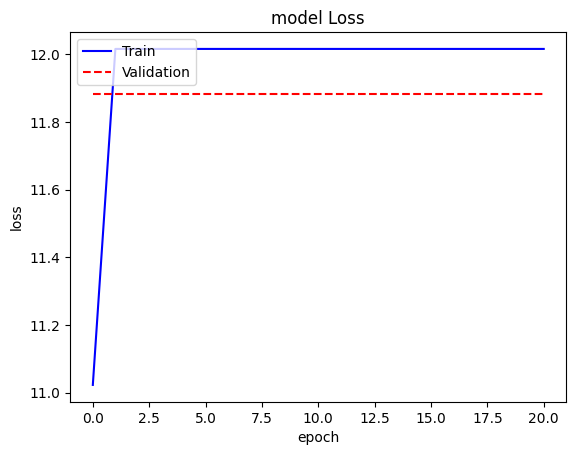

In [12]:
plt.title('model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(Loss, "b")
plt.plot(valLoss, "r--")
plt.legend(['Train', 'Validation'], loc='upper left')

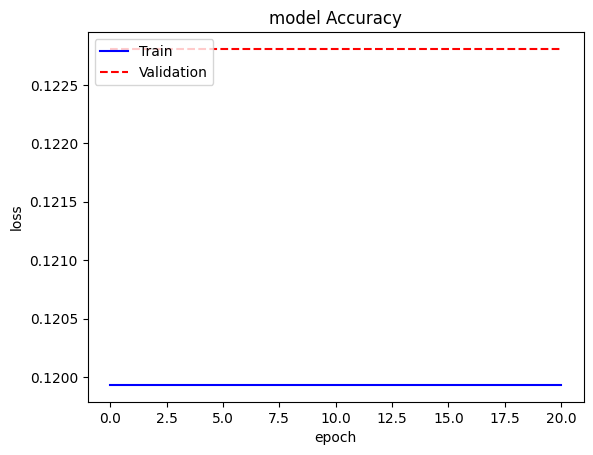

In [13]:
plt.title('model Accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(Accuracy, "b")
plt.plot(valAccuracy, "r--")
plt.legend(['Train', 'Validation'], loc='upper left')

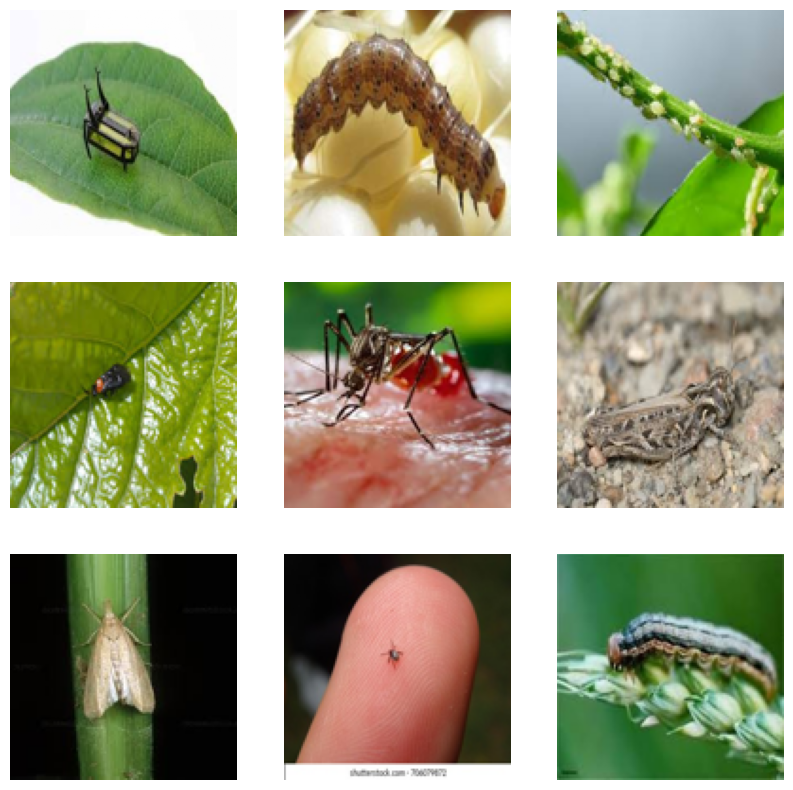

In [14]:
i, t = val_data
fig,axs = plt.subplots(3,3,figsize=(10,10))
c = []
index = np.random.randint(0, len(t))
for row in range(0, 3):
    for column in range(0, 3):
        while (t[index] in c):
            index = np.random.randint(0, len(t))
        c.append(t[index])
        
        axs[column][row].imshow(i[index])
        axs[column][row].axis('off')
